In [4]:
import os
import sys

import pandas as pd
import numpy as np
import scanpy as sc

import tacco as tc
import workflow.common_code as common_code
import pandas as pd
import matplotlib

## Plotting options

In [5]:
highres = False
default_dpi = 100.0
if highres:
    matplotlib.rcParams['figure.dpi'] = 648.0
    hr_ext = '_hd'
else:
    matplotlib.rcParams['figure.dpi'] = default_dpi
    hr_ext = ''

axsize = np.array([4,3])*0.5

labels_colors = pd.Series({'Epi': (0.00784313725490196, 0.24313725490196078, 1.0), 'B': (0.10196078431372549, 0.788235294117647, 0.2196078431372549), 'TNK': (1.0, 0.48627450980392156, 0.0), 'Mono': (0.5490196078431373, 0.03137254901960784, 0.0), 'Mac': (0.9098039215686274, 0.0, 0.043137254901960784), 'Gran': (0.34901960784313724, 0.11764705882352941, 0.44313725490196076), 'Mast': (0.23529411764705882, 0.23529411764705882, 0.23529411764705882), 'Endo': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), 'Fibro': (0.6235294117647059, 0.2823529411764706, 0.0)})


## Data reading

In [6]:
os.system(f"wget ...scRNAseq.h5ad {reference_data_path}/scRNAseq.h5ad")
reference_data_path = common_code.find_path('results/slideseq_mouse_colon/')
plot_path = common_code.find_path('results/insilico_mouse_colon', create_if_not_existent=True)
# env_path = common_code.find_path('results/env_links')
reference = sc.read_h5ad(f'{reference_data_path}/scRNAseq.h5ad')

## Mix data in-silico
### Generate in-silico mixtures of scRNA-seq data to benchmark methods with a known ground truth

In [7]:
# bead_sizes = [0.5,1.0,1.5,2.0]
bead_sizes = [10,20,30,40,50]

capture_rate = 1.0
bead_shape = 'gauss'
ntdata_max = 10**4

ref_annotation_key = 'labels'
tdata_annotation_key = 'reads_' + ref_annotation_key

sdatas = {}
for bead_size in bead_sizes:
    sdata = tc.tl.mix_in_silico(reference, type_key=ref_annotation_key, n_samples=ntdata_max, bead_shape=bead_shape, bead_size=bead_size, capture_rate=capture_rate,)
    sdata.obsm[tdata_annotation_key] /= sdata.obsm[tdata_annotation_key].to_numpy().sum(axis=1)[:,None]
    sdatas[bead_size] = sdata

In [ ]:
methods = {
    'TACCO_SpaGFT': {'method': 'OTGFT', 'multi_center': 10},
    'TACCO': {'method': 'OT', 'multi_center': 10}
}
results = {}
for bead_size in bead_sizes:
    for method,params in methods.items():
        print(f'running method {method} for bead size {bead_size} ...', end='')
        results[(bead_size, method)] = tc.benchmarking.benchmark_annotate(sdatas[bead_size],reference,annotation_key='labels',S_spagft=24,lamada_mtb=0.8,**params)
        print(f'done')

## Benchmark annotation methods on the in-silico mixtures with known ground truth
### Define parameters for the annotation methods to use

In [ ]:
for (bead_size,method),result in results.items():
    unused_key = tc.utils.find_unused_key(sdatas[bead_size].obsm)
    sdatas[bead_size].obsm[unused_key] = results[(bead_size,method)]['annotation']
    L2 = tc.ev.compute_err(sdatas[bead_size], unused_key, tdata_annotation_key, err_method='lp', p=2)[unused_key]
    del sdatas[bead_size].obsm[unused_key]
    results[(bead_size,method)]['L2'] = L2
res_df = pd.DataFrame([
    [bead_size,method,v['L2'],v['max_mem_usage_GB'],v['benchmark_time_s']]# L2, corr, max_correct, proj
    for (bead_size,method),v in results.items()
],columns=['beadsize','method','L2 error','memory (GB)','time (s)']) # L2 error, corr, max_correct, projection
quantities = [c for c in res_df.columns if c not in ['beadsize','method'] ]
methods = res_df['method'].unique()
fig,axs = tc.pl.subplots(1,len(quantities), axsize=np.array([4,3])*0.4, x_padding=0.7, y_padding=0.5)
colors = {m:common_code.method_color(m) for m in methods}
styles = {m:common_code.method_style(m) for m in methods}
res_df = res_df.loc[~res_df[quantities].isna().all(axis=1)]
for iy_ax, qty in enumerate(quantities):
    ax = axs[iy_ax,0]

    x = res_df['beadsize']
    y = res_df[qty]

    if qty == 'time (s)': # part 1 of adding second, minute and hour marker: plot the lines under the data
        ynew = np.array([0.1,1,10,60,600,3600,36000])
        ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,60,10),np.arange(60,600,60),np.arange(600,3600,600),np.arange(3600,36000,3600)]).flatten()
        ynewlabels = np.array(['0.1s','1s','10s','1min','10min','1h','10h'])
        ymin = y.min() * 0.5
        ymax = y.max() * 2.0
        ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
        ynew = ynew[(ynew > ymin) & (ynew < ymax)]
        ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
        for yn in ynew:
            ax.axhline(yn, color='gray', linewidth=0.5)

    elif qty == 'memory (GB)':
        ynew = np.array([0.1,0.4,1,4,10,40,100])
        ynew_minor = np.concatenate([np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100)]).flatten()
        ynewlabels = np.array(['0.1GB','0.4GB','1GB','4GB','10GB','40GB','100GB'])
        ymin = y.min() * 0.5
        ymax = y.max() * 2.0
        ynewlabels = ynewlabels[(ynew > ymin) & (ynew < ymax)]
        ynew = ynew[(ynew > ymin) & (ynew < ymax)]
        ynew_minor = ynew_minor[(ynew_minor > ymin) & (ynew_minor < ymax)]
        for yn in ynew:
            ax.axhline(yn, color='gray', linewidth=0.5)

    for m in methods:
        selector = res_df['method'] == m
        if selector.sum() == 0:
            continue
        ax.plot(x[selector],y[selector],label=m,marker='o',color=colors[m],ls=styles[m],)
    if iy_ax == axs.shape[0] - 1:
        ax.set_xlabel('bead size')
    if qty == 'time (s)':
        ax.set_ylabel('runtime')
    elif qty == 'memory (GB)':
        ax.set_ylabel('memory')
    else:
        ax.set_ylabel(f'{qty}')
    if qty in ['time (s)','memory (GB)']:
        ax.set_yscale('log')

    if qty in ['time (s)','memory (GB)']: # part 2 off adding second, minute and hour marker: add the second y axis after rescaling the first y axis to log scale
        ax.set_yticks(ynew_minor,minor=True)
        ax.set_yticks(ynew)
        ax.set_yticklabels(ynewlabels)
        ax.set_yticklabels([],minor=True)

    if iy_ax == 0:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

## Visualize scRNA-seq data
### Create UMAP for the scRNA-seq data

SCumap...time 18.878584146499634


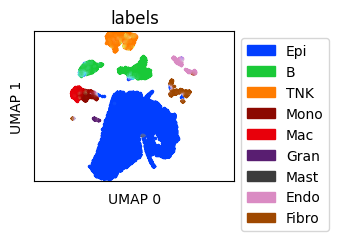

In [ ]:
ref_umap = tc.utils.umap_single_cell_data(reference)
fig = tc.pl.scatter(ref_umap, keys='labels', position_key='X_umap', colors=labels_colors, joint=True, point_size=5, axsize=axsize, noticks=True,
axes_labels=['UMAP 0','UMAP 1'])